<a href="https://colab.research.google.com/github/BrendaGonzales757/ExamenFinal/blob/main/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#instalación del entorno TradingEnv
!pip install gym-anytrading

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.2/172.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 22.7 MB/s eta 0:00:00


In [ ]:
#crear entorno
import gymnasium as gym
import gym_anytrading

env= gym.make('forex-v0')

In [ ]:
from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK, STOCKS_GOOGL

custom_env= gym.make('forex-v0', df= FOREX_EURUSD_1H_ASK,
                     window_size=10,
                     frame_bound=(10,300),
                     unit_side='right'
                     )


In [ ]:
print("env information:")
print("> shape:", env.unwrapped.shape)
print("> df.shape:", env.unwrapped.df.shape)
print("> prices.shape:", env.unwrapped.prices.shape)
print("> signal_features.shape:", env.unwrapped.signal_features.shape)
print("> max_possible_profit:", env.unwrapped.max_possible_profit())

print()
print("custom_env information:")
print("> shape:", custom_env.unwrapped.shape)
print("> df.shape:", custom_env.unwrapped.df.shape)
print("> prices.shape:", custom_env.unwrapped.prices.shape)
print("> signal_features.shape:", custom_env.unwrapped.signal_features.shape)
print("> max_possible_profit:", custom_env.unwrapped.max_possible_profit())

env information:
> shape: (24, 2)
> df.shape: (6225, 5)
> prices.shape: (6225,)
> signal_features.shape: (6225, 2)
> max_possible_profit: 4.054407219413578

custom_env information:
> shape: (10, 2)
> df.shape: (6225, 5)
> prices.shape: (300,)
> signal_features.shape: (300, 2)
> max_possible_profit: 1.1228998536878634


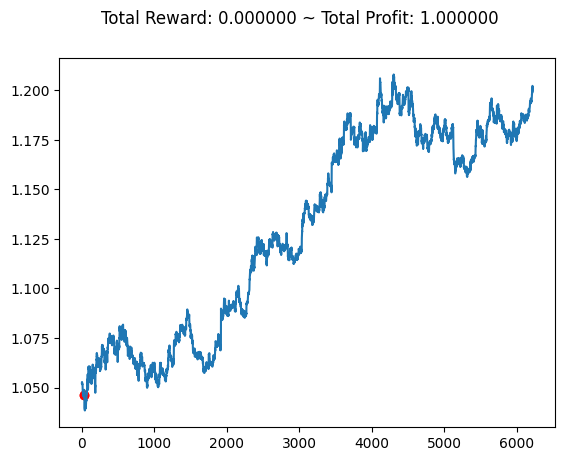

In [ ]:
env.reset()
env.render()

info: {'total_reward': -1.6939640045166016, 'total_profit': 0.9881150861195291, 'position': <Positions.Long: 1>}


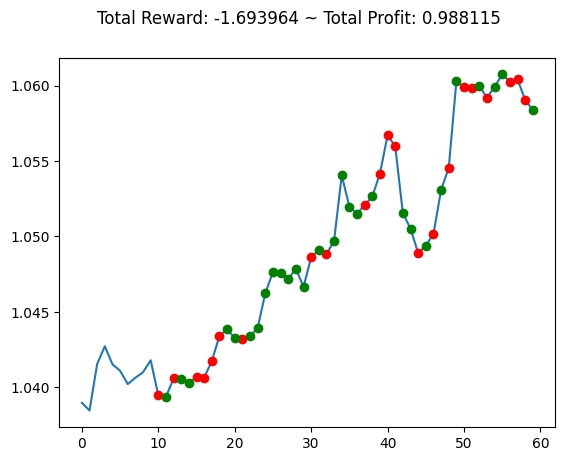

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym
import gym_anytrading
from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions
from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK, STOCKS_GOOGL


env = gym.make('forex-v0', frame_bound=(50, 100), window_size=10)
# env = gym.make('stocks-v0', frame_bound=(50, 100), window_size=10)

observation = env.reset(seed=42)
while True:
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # env.render()
    if done:
        print("info:", info)
        break

plt.cla()
env.unwrapped.render_all()
plt.show()

In [ ]:
!pip install gym-mtsim

  Using cached pandas-2.2.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
Using cached pandas-2.2.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.1 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.10.1 requires pandas<2.2.3dev0,>=2.0, but you have pandas 2.2.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [ ]:
!pip install stable-baselines3

In [ ]:
pip install --upgrade gymnasium gym-mtsim pandas

In [ ]:
import gymnasium as gym
import gym_mtsim

env = gym.make('forex-hedge-v0')


In [ ]:
import pytz
from datetime import datetime, timedelta
import numpy as np
from gym_mtsim import MtEnv, MtSimulator, FOREX_DATA_PATH


sim = MtSimulator(
    unit='USD',
    balance=10000.,
    leverage=100.,
    stop_out_level=0.2,
    hedge=True,
    symbols_filename=FOREX_DATA_PATH
)

env = MtEnv(
    original_simulator=sim,
    trading_symbols=['GBPCAD', 'EURUSD', 'USDJPY'],
    window_size=10,
    # time_points=[desired time points ...],
    hold_threshold=0.5,
    close_threshold=0.5,
    fee=lambda symbol: {
        'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
        'EURUSD': max(0., np.random.normal(0.0002, 0.00003)),
        'USDJPY': max(0., np.random.normal(0.02, 0.003)),
    }[symbol],
    symbol_max_orders=2,
    multiprocessing_processes=2
)

In [ ]:
print("env information:")

for symbol in env.prices:
    print(f"> prices[{symbol}].shape:", env.prices[symbol].shape)

print("> signal_features.shape:", env.signal_features.shape)
print("> features_shape:", env.features_shape)

env information:
> prices[GBPCAD].shape: (88, 2)
> prices[EURUSD].shape: (88, 2)
> prices[USDJPY].shape: (88, 2)
> signal_features.shape: (88, 6)
> features_shape: (10, 6)


In [ ]:
observation = env.reset()

while True:
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    if done:
        # print(info)
        print(
            f"balance: {info['balance']}, equity: {info['equity']}, margin: {info['margin']}\n"
            f"free_margin: {info['free_margin']}, margin_level: {info['margin_level']}\n"
            f"step_reward: {info['step_reward']}"
        )
        break

balance: 8122.192116476015, equity: 10516.684476900702, margin: 7789.6672
free_margin: 2727.017276900702, margin_level: 1.3500813586619853
step_reward: 184.2400000000398


In [ ]:
state = env.render()

print(
    f"balance: {state['balance']}, equity: {state['equity']}, margin: {state['margin']}\n"
    f"free_margin: {state['free_margin']}, margin_level: {state['margin_level']}\n"
)
state['orders']

balance: 8122.192116476015, equity: 10516.684476900702, margin: 7789.6672
free_margin: 2727.017276900702, margin_level: 1.3500813586619853



,Id,Symbol,Type,Volume,Entry Time,Entry Price,Exit Time,Exit Price,Exit Balance,Exit Equity,Profit,Margin,Fee,Closed
0,11,EURUSD,Buy,6.58,2021-09-01 00:00:00+00:00,1.18384,2021-09-03 00:00:00+00:00,1.18772,NaN,NaN,2394.492360,7789.6672,0.000241,False
1,10,USDJPY,Sell,0.90,2021-08-06 00:00:00+00:00,110.21700,2021-08-10 00:00:00+00:00,110.56000,8122.192116,8122.192116,-294.812748,900.0000,0.019161,True
2,9,USDJPY,Buy,16.52,2021-07-23 00:00:00+00:00,110.54700,2021-07-27 00:00:00+00:00,109.77400,8417.004865,8417.004865,-11844.504791,16520.0000,0.014057,True
3,8,USDJPY,Buy,3.24,2021-07-15 00:00:00+00:00,109.83100,2021-07-16 00:00:00+00:00,110.08100,20261.509656,20261.509656,659.561742,3240.0000,0.025910,True
4,4,EURUSD,Sell,0.01,2021-07-07 00:00:00+00:00,1.17903,2021-07-15 00:00:00+00:00,1.18118,19601.947914,19601.947914,-2.362878,11.7903,0.000213,True
5,7,USDJPY,Sell,8.52,2021-07-13 00:00:00+00:00,110.62700,2021-07-14 00:00:00+00:00,109.95000,19604.310792,19599.547914,5088.803768,8520.0000,0.020293,True
6,6,EURUSD,Sell,8.48,2021-07-13 00:00:00+00:00,1.17765,2021-07-14 00:00:00+00:00,1.18358,14515.507025,19599.547914,-5210.384604,9986.4720,0.000214,True
7,5,EURUSD,Sell,4.62,2021-07-12 00:00:00+00:00,1.18606,2021-07-13 00:00:00+00:00,1.17765,19725.891629,19727.058750,3796.052733,5479.5972,0.000193,True
8,3,EURUSD,Sell,3.14,2021-07-01 00:00:00+00:00,1.18497,2021-07-02 00:00:00+00:00,1.18646,15929.838896,15929.838896,-532.022792,3720.8058,0.000204,True
9,2,EURUSD,Sell,2.95,2021-06-29 00:00:00+00:00,1.18960,2021-06-30 00:00:00+00:00,1.18560,16461.861688,16461.861688,1115.040560,3509.3200,0.000220,True


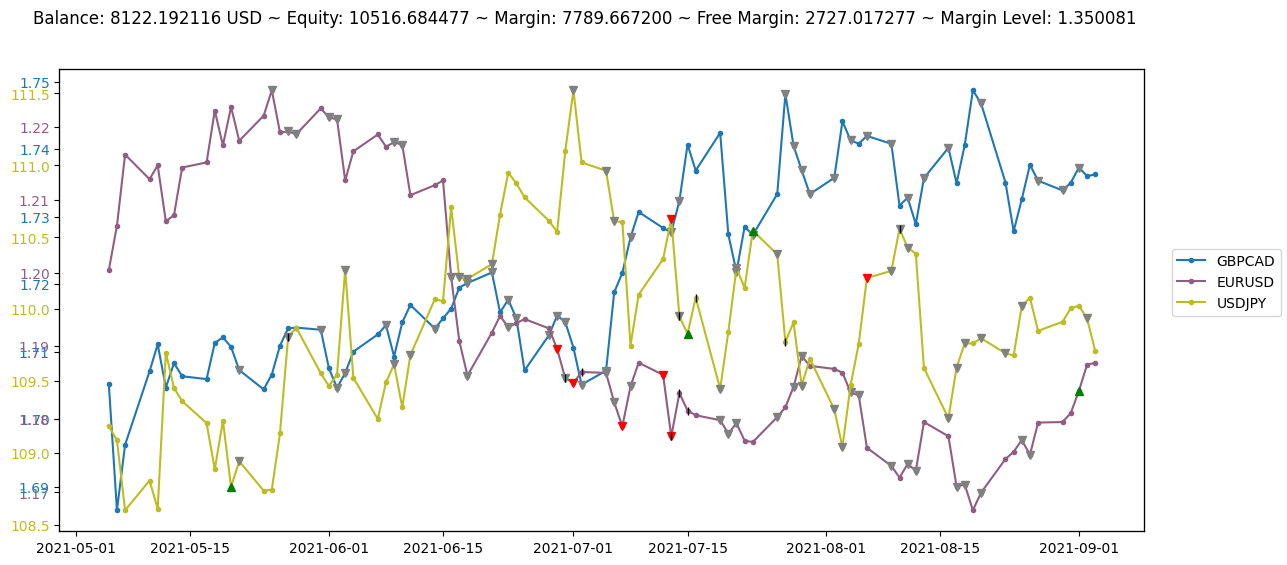

In [ ]:
env.render('simple_figure')

In [ ]:
import gymnasium as gym
from gym_mtsim import (
    Timeframe, SymbolInfo,
    MtSimulator, OrderType, Order, SymbolNotFound, OrderNotFound,
    MtEnv,
    FOREX_DATA_PATH, STOCKS_DATA_PATH, CRYPTO_DATA_PATH, MIXED_DATA_PATH,
)
from stable_baselines3 import A2C
from stable_baselines3.common.vec_env import DummyVecEnv
import random
import numpy as np
import torch

env_name = 'forex-hedge-v0'

# reproduce training and test
seed = 2024
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

env = gym.make(env_name)
model = A2C('MultiInputPolicy', env, verbose=0)
model.learn(total_timesteps=1000)

observation, info = env.reset(seed=seed)

while True:
    action, _states = model.predict(observation)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    if done:
        break

env.unwrapped.render('advanced_figure', time_format='%Y-%m-%d')

/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])  # type: ignore[arg-type]
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])  # type: ignore[arg-type]
